# Lab 3 - Feature Importance and Global Surrogates
In this lab we will use Feature Permutation to determine the feature importance of built models, both classification and regression models.

First, you are asked to implement feature permutation by yourself on a neural network classifier trained on a breast cancer dataset, then to compare your permutation scores to the prebuilt methods that exist.
Then, the same is to be performed on a neural network regressor.

Finally, you are to build a surrogate model to try and explain/interpret how a support vector machine (SVM) model makes its decisions by training a decision tree based on the predictions from the SVM.

## Installation for Google Colab
Run the cell below to install the required packages to use the notebook in Google Colab.

You might get an error saying Google Colab requires Pandas 1.5.1. Ignore that and just restart the session from the menu above: **Runtime** -> **Restart Session**.

After you installed the packages and restarted the session, you can continue with the lab.

**Remember, if you take a longer break or divide your work over several days you will have to reinstall the packages by running the cell below again and restarting the session.**

In [ ]:
%pip install -U scikit-learn==1.4.1.post1 shap==0.45.0 lime==0.2.0.1 graphviz==0.20.2 dtreeviz==2.2.2 eli5==0.13.0 xgboost==2.0.3 pandas==2.2.1 seaborn==0.13.2 numpy==1.26.4

## Package import

In [ ]:
import pandas as pd
import numpy as np

from sklearn import metrics, datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.datasets import load_breast_cancer, load_diabetes, load_iris
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

import pickle

## Upload the built models to Colab
If you are using Colab, run the cell below and then press the button "Choose files". Navigate to the **model_bc.pkl** and **model_diab.pkl** files that you downloaded from the lab page on Blacboard, and upload them. We will use them later on the lab.


In [ ]:
#from google.colab import files
#uploaded = files.upload()

# Feature Importance by Permutation
Identify and analyse the feature importance by permuting the values in a column by column basis.

## Classifier
Here, we provide a black box model using a Multi Layer Perceptron classifier that has been trained on the [breast cancer dataset](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic). Your task is to identify which features are most important for the model using feature permutation.

In [ ]:
data = load_breast_cancer()
X = pd.DataFrame(data['data'])
y = data['target']
X.columns = data['feature_names']
X=(X-X.min())/(X.max()-X.min())

#X.head()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.33)

Load the black box model.

In [ ]:
f = open('model_bc.pkl', 'rb')
clf = pickle.load(f)
f.close()

If loading the black box model does not work, run the cell below to train the model yourself. It might take a while...

### Todo
Implement feature permutation for the **clf** model and use the models built in scorer. Remember to permute the features multiple times as the results will vary depending on how the data is permuted. Present the results as the average result with standard deviations for each feature. \
You can find the pseudo-code in your lecture [Feature importance, Slide 22](https://bb.hh.se/ultra/courses/_17375_1/outline/file/_721493_1) or in the book [here](https://christophm.github.io/interpretable-ml-book/feature-importance.html).

In [ ]:
import random
import numpy as np
import pandas as pd

# Set seed for NumPy
np.random.seed(42)

# Set seed for Python's random module
random.seed(42)

y_pred = clf.predict(X_test)  # Predictions on the test set

def calculate_feature_importances(clf, X_test, y_test, n_repeats=30, random_state=42):
    # Get original score using model's own scoring method
    original_score = clf.score(X_test, y_test)
    feature_importances = {}
    feature_importances_std = {}

    # Create a random number generator with fixed seed
    rng = np.random.RandomState(random_state)

    for j in range(X_test.shape[1]):
        importance_scores = []
        for _ in range(n_repeats):
            X_perm_j = X_test.copy()
            # Use the controlled random generator
            X_perm_j.iloc[:, j] = rng.permutation(X_perm_j.iloc[:, j])
            # Use model's own scoring method
            permuted_score = clf.score(X_perm_j, y_test)
            # Note: For most sklearn models, higher score means better performance
            # so we use (original - permuted) to get positive values for important features
            importance_scores.append(original_score - permuted_score)

        feature_importances[X_test.columns[j]] = np.mean(importance_scores)
        feature_importances_std[X_test.columns[j]] = np.std(importance_scores)

    feature_importances_df = pd.DataFrame({
        'Importance': feature_importances,
        'StdDev': feature_importances_std
    })

    return feature_importances_df.sort_values(by='Importance', ascending=False)

feature_importances_difference = calculate_feature_importances(clf, X_test, y_test)
print("\nFeature Importances (using model's score method):\n", feature_importances_difference)


Feature Importances (using model's score method):
                            Importance    StdDev
worst texture            5.301418e-02  0.017015
mean concave points      3.173759e-02  0.014105
worst radius             3.102837e-02  0.016993
mean concavity           1.719858e-02  0.009583
worst area               1.471631e-02  0.011046
worst concave points     1.400709e-02  0.008520
mean compactness         1.028369e-02  0.009897
radius error             1.028369e-02  0.007387
worst perimeter          9.929078e-03  0.009389
worst concavity          9.574468e-03  0.013202
worst smoothness         5.141844e-03  0.009563
area error               4.432624e-03  0.004139
perimeter error          2.659574e-03  0.003568
concave points error     1.241135e-03  0.003274
worst symmetry           5.319149e-04  0.008166
mean area                0.000000e+00  0.000000
concavity error         -3.700743e-18  0.001373
texture error           -5.319149e-04  0.005381
smoothness error        -1.063830e-0

Of course there already exist implemented functionality to perform feature permutation, for instance with **sklearn**.

See if your own results from feature permutation aligns with the ones produced in the cells below.

In [ ]:
from sklearn.inspection import permutation_importance
r = permutation_importance(clf, X_test, y_test,
                           n_repeats=30,
                           random_state=42)

for i in r.importances_mean.argsort()[::-1]:
        print(f'{X.columns[i]:<19} '
              f'{r.importances_mean[i]:.3f}'
              f' +/- {r.importances_std[i]:.3f}')


worst texture       0.057 +/- 0.015
mean concave points 0.029 +/- 0.012
worst radius        0.027 +/- 0.016
mean compactness    0.012 +/- 0.010
mean concavity      0.011 +/- 0.012
worst concave points 0.011 +/- 0.011
worst area          0.009 +/- 0.009
worst concavity     0.008 +/- 0.015
radius error        0.008 +/- 0.007
worst perimeter     0.005 +/- 0.010
texture error       0.004 +/- 0.005
perimeter error     0.002 +/- 0.004
area error          0.002 +/- 0.004
worst smoothness    0.002 +/- 0.007
concave points error 0.001 +/- 0.003
mean fractal dimension 0.000 +/- 0.006
concavity error     -0.000 +/- 0.001
smoothness error    -0.000 +/- 0.004
worst compactness   -0.001 +/- 0.007
worst symmetry      -0.001 +/- 0.010
mean area           -0.001 +/- 0.002
mean perimeter      -0.002 +/- 0.003
mean radius         -0.002 +/- 0.003
worst fractal dimension -0.002 +/- 0.003
mean texture        -0.002 +/- 0.003
mean symmetry       -0.002 +/- 0.003
symmetry error      -0.006 +/- 0.005
compactn

### Reflection

#### What do the results above mean?

* That `worst texture`, `mean concave points` and `worst radius ` seem to be significantly more important for the result of the predictions than the other features.

* "Worst"-prefixed features tend to be more predictive than mean values

* Error-related features generally have low or negative importance

* There is some difference between sklearns implementation and mine, I couldnt find the reason.


#### What conclusions/insights can we draw of the model based of off them?

* Some features had negative feature importance, meaning that randomly shuffling that feature's values actually improved the model's performance. This could mean that the feature just added noise that was confusing to the model or perhaps the model overfitted to patterns in this feature. It could also be that the model finds some coincidental correlation for the feature in the training data that doesnt exist in the test data, which can make the model worse.

* Removing some features (with negative/low importance) would be a good step to improve the model, both improving performance and simplify the model.

## Regression
The same task as before lies ahead of you, but in this instance we instead look towards the Multi Layer Perceptron for regression. This model has been trained on a [diabets dataset](https://rowannicholls.github.io/python/data/sklearn_datasets/diabetes.html) where the target variable is the disease progression.

In [ ]:
data = load_diabetes()
X = pd.DataFrame(data['data'])
y = data['target']
X.columns = data['feature_names']

X.head()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.33)

Load the black box model.

In [ ]:
f = open('model_diab.pkl', 'rb')
clf = pickle.load(f)
f.close()

### Todo
Implement feature permutation for the **clf** model and use the models built in scorer. Remember to permute the features multiple times as the results will vary. Present the results as the average result with standard deviations for each feature.

In [ ]:
import random
import numpy as np
import pandas as pd

# Set seed for NumPy
np.random.seed(42)

# Set seed for Python's random module
random.seed(42)

y_pred = clf.predict(X_test)  # Predictions on the test set

def calculate_feature_importances(clf, X_test, y_test, n_repeats=30, random_state=42):
    # Get original score using model's own scoring method
    original_score = clf.score(X_test, y_test)
    feature_importances = {}
    feature_importances_std = {}

    # Create a random number generator with fixed seed
    rng = np.random.RandomState(random_state)

    for j in range(X_test.shape[1]):
        importance_scores = []
        for _ in range(n_repeats):
            X_perm_j = X_test.copy()
            # Use the controlled random generator
            X_perm_j.iloc[:, j] = rng.permutation(X_perm_j.iloc[:, j])
            # Use model's own scoring method
            permuted_score = clf.score(X_perm_j, y_test)
            # Note: For most sklearn models, higher score means better performance
            # so we use (original - permuted) to get positive values for important features
            importance_scores.append(original_score - permuted_score)

        feature_importances[X_test.columns[j]] = np.mean(importance_scores)
        feature_importances_std[X_test.columns[j]] = np.std(importance_scores)

    feature_importances_df = pd.DataFrame({
        'Importance': feature_importances,
        'StdDev': feature_importances_std
    })

    return feature_importances_df.sort_values(by='Importance', ascending=False)

feature_importances_difference = calculate_feature_importances(clf, X_test, y_test)
print("\nFeature Importances (using model's score method):\n", feature_importances_difference)


Feature Importances (using model's score method):
      Importance    StdDev
s5     0.407495  0.055253
s1     0.278439  0.053381
bmi    0.231952  0.041654
s2     0.153252  0.025637
bp     0.089547  0.023386
sex    0.053339  0.016100
s4     0.030916  0.011773
s3     0.000875  0.000722
age   -0.000556  0.002319
s6    -0.002674  0.001391


In [ ]:
r = permutation_importance(clf, X_test, y_test,
                           n_repeats=30,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
        print(f"{X.columns[i]:<19} "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")


s5                  0.398 +/- 0.048
s1                  0.286 +/- 0.046
bmi                 0.217 +/- 0.042
s2                  0.148 +/- 0.029
bp                  0.079 +/- 0.027
sex                 0.056 +/- 0.020
s4                  0.029 +/- 0.009
s3                  0.001 +/- 0.001
age                 -0.002 +/- 0.002
s6                  -0.003 +/- 0.001


### Reflection

#### What do the results above mean?

* That `s5`, `s1`, `bmi` and `s2` seem to be significantly more important for the result of the predictions than the other features.

* There is some difference between sklearns implementation and mine, I couldnt find the reason.

* The standard deviations provide confidence in these assessments, with larger values for the most important features indicating consistent importance across permutation tests


#### What conclusions/insights can we draw of the model based of off them?

* The `age` and `s6` features had negative feature importance, meaning that randomly shuffling that feature's values actually improved the model's performance. This could mean that the feature just added noise that was confusing to the model or perhaps the model overfitted to patterns in this feature. It could also be that the model finds some coincidental correlation for the feature in the training data that doesnt exist in the test data, which can make the model worse.

* Removing some features (with negative/low importance) would be a good step to improve the model, both improving performance and simplify the model.

# Global Surrogate
In this part of the lab you will be tasked to train Support Vector Machines (SVMs) on two given datasets. The SVMs are then to be subject for the global surrogate approach, where you will train CART models on the input data and the output from the SVMs.

## Classification

Here, you create a SVM. THe SVM is then used to predict data which is then fed into the CART algorithm to train.
This mimics the model from the SVM into the cart model, which is cheaper to use.
You can find the Iris dataset [here](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-plants-dataset).

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

data = load_iris()
X = pd.DataFrame(data['data'])
X.columns = data['feature_names']
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.33)


In [ ]:
clf = SVC()
clf.fit(X_train, y_train)

SVC()

In [ ]:
from sklearn.metrics import r2_score
surrogate = DecisionTreeClassifier()
surrogate.fit(X_train, clf.predict(X_train))
y_pred = surrogate.predict(X_test)

r2_score(y_test, y_pred)

0.9712808730614589

Visualize the tree and try and see how the CART approximates the SVM.

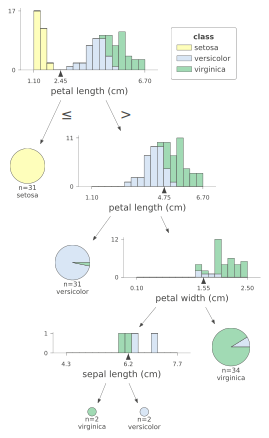

In [ ]:
# Visualize tree
import dtreeviz

viz = dtreeviz.model(surrogate, X_train, y_train,
                     target_name='class',
                     feature_names=X_train.columns.tolist(),
                     class_names=data['target_names'])
viz.view(fontname='Dejavu Sans')

### How the SVM is Approximated
The decision tree approximates an SVM by creating a series of axis-parallel decision boundaries (perpendicular splits on feature axes) that attempt to mimic the more complex decision boundaries that an SVM would create. While SVMs use hyperplanes or kernel transformations to find optimal boundaries, the decision tree creates a piecewise approximation through hierarchical binary splits. In this case it well approximates the SVM model, with a R^2 score of 0.97.

### Most Important Features

Petal Length: Clearly the most important feature, used for the primary split at 2.45 cm (completely separating setosa from other species) and again at the second level (4.75 cm)

Petal Width: Second most important feature, used to distinguish between versicolor and virginica at around 1.55 cm

Sepal Length: Used only at the bottom of the tree with less discriminative power (threshold at 6.2 cm)

Sepal Width: Not used in the major decision boundaries, suggesting minimal importance in this model

### How It Operates
The tree operates through a sequence of binary decisions:

First check if petal length ≤ 2.45 cm

If yes → classify as setosa (n=31, 100% accuracy)
If no → continue
For samples with longer petals, check if petal length > 4.75 cm

If no → mostly versicolor samples, classify as versicolor
If yes → mostly virginica samples
Then evaluate petal width (≤ or > 1.55 cm)

If ≤ 1.55 cm → classify as versicolor (n=31)
If > 1.55 cm → continue to evaluate sepal length
Finally, use sepal length (threshold at 6.2 cm) for the final classification refinement.

## Regression

You can find the diabetes dataset [here](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset).

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

data = load_diabetes()
X = pd.DataFrame(data['data'])
X.columns = data['feature_names']
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.33)

In [ ]:
clf = SVR()
clf.fit(X_train, y_train)

SVR()

In [ ]:
surrogate = DecisionTreeRegressor(max_depth=4)
surrogate.fit(X_train, clf.predict(X_train))
y_pred = surrogate.predict(X_test)

r2_score(y_test, y_pred)

0.11917710848714325

Visualize the tree and try and see how the CART approximates the SVR.

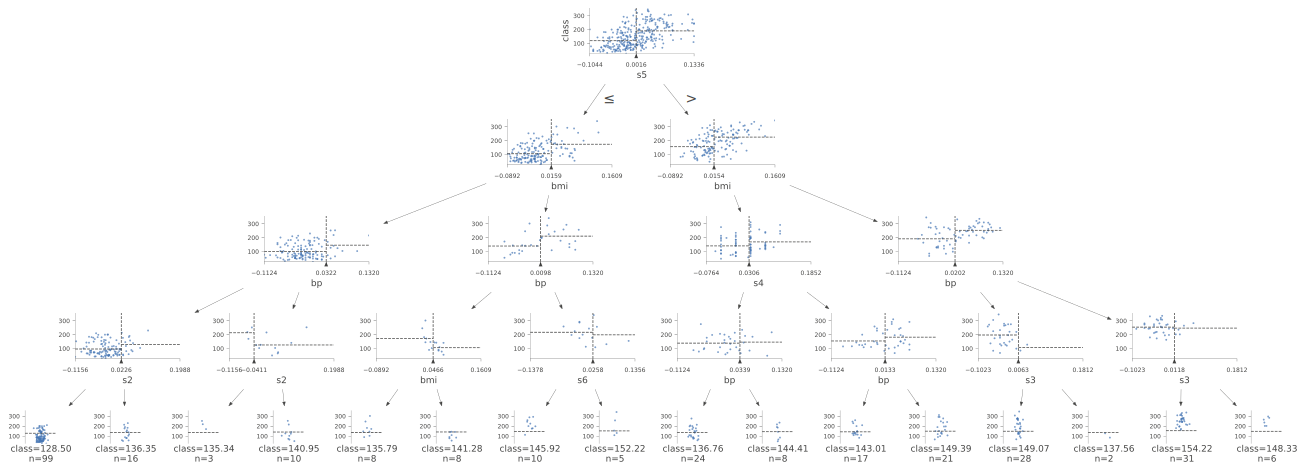

In [ ]:
#Visualize the tree
import dtreeviz

viz = dtreeviz.model(surrogate, X_train, y_train,
                     target_name='class',
                     feature_names=X_train.columns.tolist())
viz.view(fontname='Dejavu Sans')

* How is the SVM approximated?
* What features give the most importance to the model?
* How does it operate?

* Note: I set max_depth=4 to be able to interpret the surrogate model.

### How SVR is Approximated
The approximation is a form of model distillation where a simpler model (decision tree) attempts to mimic the behavior of a more complex model (SVR). The process involved:

Training an SVR model on the diabetes dataset
Using the SVR's predictions as target values
Training a DecisionTreeClassifier to predict these values
The R² score of 0.119 indicates the tree captures about 12% of the variance in the SVR's predictions

### Most Important Features
Looking at the decision tree visualization, the feature importance can be determined by their position and frequency in the tree:

s5: Used at the root node, making it the most influential feature
bmi (Body Mass Index): Used at the second level splits
bp (Blood Pressure): Appears multiple times at the third level
s2, s3, and s6: Appear in deeper levels of the tree
Features used near the top of the tree have the greatest impact on predictions as they affect all samples passing through them.

### How the Model Operates
The decision tree works through a series of binary decisions:

It first checks if feature 's5' is above or below a threshold (around 0.0016)
Based on that outcome, it examines 'bmi' against different thresholds
It continues making decisions based on features like 'bp', 's4' and so on.
Each path ends in a leaf node containing:
A prediction value (the "class=XXX.XX" values) and the number of samples in that leaf (n).

Each node splits the data to maximize homogeneity in the resulting subsets. The rectangular decision boundaries created by the tree are attempting to approximate the probably more complex, non-linear decision boundaries of the SVR model.

The relatively low R² score suggests that while the tree provides an interpretable approximation of the SVR, it misses some of the complexity that the SVR model captures.

The relatively low R² score suggests that while the tree provides an interpretable approximation of the SVR, it misses some of the complexity that the SVR model captures. This suggests the relationship between features and the target is complex and not fully captured by the rectangular decision boundaries of a tree.

# Final reflections

Reflect about your laboration. This includes but is not limited to the example points below.

* How does the feature permutation give us insight to explain the model?
* What conclusions can you draw from it?
* The Global surrogate model takes another approach to explain the model. Is it useful?
* How can you use the surrogate to explain your model?


### Feature Permutation for Model Explanation
Feature permutation provides valuable insights by:

* Measuring true feature importance: It shuffles one feature's values while keeping others intact and measures the drop in performance
* Model-agnostic approach: Works with any model type, including complex "black box" models like SVR
* Unbiased assessment: Unlike built-in importance measures, it shows how much performance actually depends on each feature


### Conclusions from feature permutation:

Features causing larger performance drops when permuted are more crucial to the model's predictions.
Features with minimal impact when shuffled may be candidates for removal
The technique helps identify which features actually drive predictions versus those that merely correlate with important features


### Global Surrogate Models Usefulness
Decision trees was used as global surrogate models for SVM and SVR and they offered the following explanatory value:

* Visual interpretability: Provides a human-readable visualization of decision logic
* Feature hierarchy: Clearly shows which features (s5, bmi, bp) have the greatest impact
* Decision boundaries: Illustrates how feature thresholds create prediction regions
* Interaction insights: Reveals how features interact in sequences of decisions

### How to use the surrogate effectively:

* Explain key decision paths: Walk stakeholders through the most common paths in the tree
* Identify critical thresholds: Point out the most influential split points (like the s5 threshold at the root for the SVR)
* Compare with domain knowledge: Validate whether the decision structure aligns with clinical understanding of for example diabetes
* Acknowledge limitations: Be transparent about the surrogate's approximation quality (R² = 0.119 in the SVR case)
* Combine with other techniques: Use alongside feature permutation for a more complete explanation